In [1]:
import numpy as np
import scipy as spy
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {}
import seaborn as sns
import pandas as pd
from pyswmm_lite import Env
import pickle
from automate_objective import generate_targets, generate_weights
from utilities_baeopt import swmm_execute
import matplotlib.pyplot as plt
from GPyOpt.methods import BayesianOptimization
import requests
np.random.seed(42)

In [2]:
def generate_waves(window_len, cycles, magnitude = 1.0):
    half_wave = np.hstack((np.sin(np.linspace(0, 1.0, window_len)*np.pi),np.zeros([window_len]))) * magnitude
    flow = np.zeros([2*window_len*cycles])
    counter = 0
    for i in range(0, cycles):
        start_dim = counter
        end_dim = counter+(2*window_len)
        flow[start_dim:end_dim] = half_wave
        counter = counter+(2*window_len)
    return flow

In [3]:
ensemble = [generate_waves(100, 1, i) for i in np.linspace(0.1, 1.0, 20)]

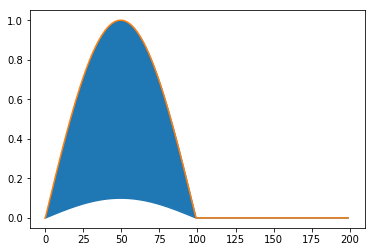

In [4]:
plt.plot(ensemble[0])
plt.plot(ensemble[-1])
plt.fill_between(np.linspace(0, 200, 200), ensemble[0], ensemble[-1])
plt.show()

Let us assume that we are expecting the rainfall to be bounded between these curves. So when the agent samples for an acquision, it can experience any rainfall in the bounded region.

**This would just be for input uncertanity, we will model the model uncertanity in the next session.**

In [5]:
# Create the objective function 
NODES_LIS = {"P1":"1", "P2":"2"}
def swmm_execute(x,
        inflow,
        ctrl_elemnts = ["P1"],
        network="./networks/parallel.inp",
        meta_data=NODES_LIS):
    """
    Run the controlled simuation

    Parameters:
    ------------------------------------------------
    x : control actions  
    network : path to network 
    meta_data : nodes list 

    Returns:
    ------------------------------------------------
    data: Dict of pandas dataframe with keys as outflow, depth, flooding
    and inflows 

    """
    env = Env(network)

    data = {}
    data["outflows"] = {}
    data["inflows"] = {}
    data["flooding"] = {}
    data["depth"] = {}

    for attribute in data.keys():
        for node in meta_data.keys():
            data[attribute][node] = []
    
    # Set the valve positions 
    valve_positions = []
    for i in range(0, x.shape[1]):
        valve_positions.append(x[0][i])

    for time in range(0, len(inflow)):
        env.sim._model.setNodeInflow("P1", 3*inflow[time])
        env.sim._model.setNodeInflow("P2", 0.0)
        done = env.step()

        for valve,valve_position in zip(ctrl_elemnts, valve_positions):
            env.set_gate(NODES_LIS[valve], valve_position)

        # record the data
        for node in NODES_LIS.keys():
            data["outflows"][node].append(env.flow(NODES_LIS[node]))
            data["flooding"][node].append(env.get_flooding(node))
            data["depth"][node].append(env.depthN(node))
            data["inflows"][node].append(env.get_inflow(node))

    data["error"] = env.sim._model.runoff_routing_stats()
    env.terminate()
    
    # Convert to data frames 
    data["outflows"] = pd.DataFrame.from_dict(data["outflows"])
    data["inflows"]  = pd.DataFrame.from_dict(data["inflows"])
    data["flooding"] = pd.DataFrame.from_dict(data["flooding"])
    data["depth"] = pd.DataFrame.from_dict(data["depth"])

    return data

In [6]:
data = swmm_execute(np.asarray([[1.0]]), ensemble[-1])

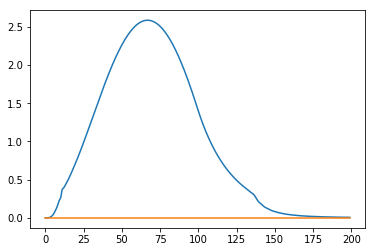

In [7]:
plt.plot(data["outflows"])

In [8]:
def performance_measure(data):
    outflows = data["outflows"]
    flooding = data["flooding"]
    # Get the performance metric 
    perforamce  = 0.0
    # Check if there is flooding in the assets 
    flooding = flooding.gt(0.0)
    flooding = flooding.any()
    if flooding.any(): 
        perforamce += 10**8
    # Estimate the perfomance from the flows
    outflows = outflows.sub(0.5)
    outflows[outflows < 0.0] = 0.0
    outflows = outflows.sum()
    for i in outflows.keys():
        perforamce += outflows[i]
    return perforamce

In [9]:
def objective_function(x):
    # Run SWMM and get the trajectories 
    rain_choice = int(np.random.choice(20, 1))
    inflow = ensemble[rain_choice]
    data = swmm_execute(x, inflow)
    obj_value = performance_measure(data)
    return obj_value

# Create the domain
domain = []
for i in range(1, 2):
    domain.append({'name': 'var_'+str(i), 'type': 'continuous', 'domain': (0.0, 1.0)})

In [10]:
# Solve the bayesian optimization 
myBopt = BayesianOptimization(f=objective_function, domain=domain, model_type = 'GP', acquisition_type='EI')

In [11]:
save_path = "."
myBopt.run_optimization(save_path, max_iter=50, save_inter_models=False, intervals=10, verbosity=False)

In [12]:
myBopt.x_opt

array([0.19158286])

In [14]:
random_performance = []
for i in range(0, 50):
    random_performance.append(objective_function(myBopt.x_opt.reshape(1,1)))

(array([12.,  2.,  0.,  7.,  3.,  1.,  6.,  4.,  7.,  8.]),
 array([ 0.        ,  5.21240926, 10.42481851, 15.63722777, 20.84963703,
        26.06204628, 31.27445554, 36.48686479, 41.69927405, 46.91168331,
        52.12409256]),
 <a list of 10 Patch objects>)

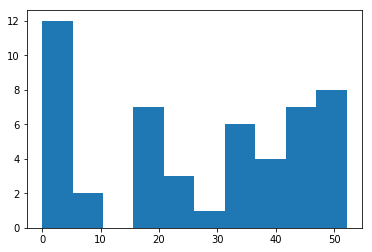

In [15]:
plt.hist(random_performance)

In [16]:
random_performance = np.asarray(random_performance)
random_performance = random_performance

In [17]:
random_performance.mean()

26.899882147847705

In [18]:
np.std(random_performance, dtype=np.float64)

18.49162169226696

There is a limit to which the uncertanity in the rainfall impacts the performance metric. Unless there is a significant impact from the rainfall onto the performance. Bayesian optimization would fail to recoungnize the uncertanity bounds.